# 3F1 Flight Control Lab
## Part 1: Pre-Flight Checks

### 1.1 The flight control experiment

The setting for this experiment is the control of a simulated aeroplane. When you run the simulation, you will see a rendering of a Heads-Up Display (HUD), pictured below.

![HUD Example](images/hud_illustration.png)

The red line corresponds to $y(t)$, the pitch angle of the plane. If $|y(t)|$ ever exceeds 10, the airplane is deemed to have crashed and the simulation stops.

The pitch is controlled by the signal $u(t)$, which is rendered on the HUD as a cyan target. In manual control mode, you play the role of the pilot: $u(t)$ is controlled by moving your mouse cursor up and down.

The objective of the controller is to have the plane fly level. This means that the reference signal $r(t)$ is 0. This is indicated by white ticks in the centre of the HUD.

The plane may be subject to external disturbances, described by $d(t)$.

To phrase this in the language of Control Theory, consider the familiar block diagram below:

![Block Diagram](images/block_diagram.png)

In this diagram, the plant corresponds to the plane, and the controller corresponds to _you_ (up until later in the lab, when you will implement a simple autopilot).

### 1.2 Material to include in your report

To help you with consolidating the appropriate material for a report, this notebook includes colour-coded prompts for items of interest:

* <font color="red">[FIGURE]</font> indicates that you should save a figure. You may wish to annotate it with salient features.
* <font color="orange">[WORKSHEET]</font> indicates an element to complete on your worksheet (included with the handout), such as a quantity to write down. You should complete this as you work through the lab.
* <font color="purple">[REPORT]</font> indicates a question you should answer on the Report Template (included with the handout). You should come back to these questions once you have completed the lab. You may need to refer to your figures or worksheet answers to justify your answer.

You _should not_ write a full report (with introductions, aims, objectives, etc.) for the 3F1 Lab. All that is required is:

1. A cover sheet
2. A completed worksheet
3. Written answers completed in the Report Template. Handwritten answers are acceptable, keep answers succinct.
4. The requested figures/plots, titled and annotated where appropriate.

These should be consolidated (in order) into a single PDF file and uploaded to Moodle.

### 1.3 Running the flight simulation

The code below shows an example of how to run the flight simulation with manual control. Run this code and attempt to fly the airplane around by moving your mouse up and down. Once the simulation finishes (which is configured to be 15 seconds in this example), it provides a set of results which describe the evolution of $e(t)$ and $u(t)$ over time. We can use the `plot_flight` function, explained in more detail below, to visualise what happened during the simulation.

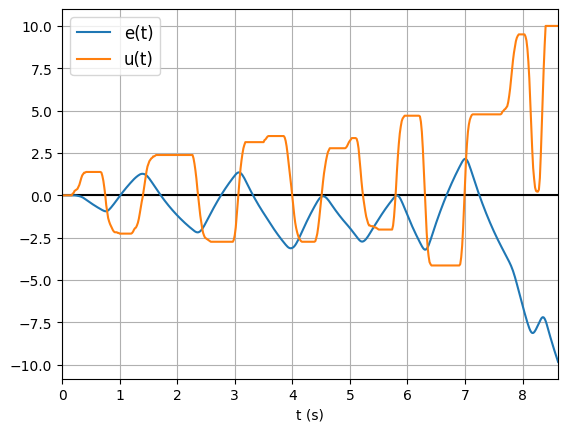

In [6]:
# Import the various libraries we need for the lab to run
from flight_control.simulation import run_simulation
from flight_control.controller import ManualControl
from flight_control.disturbances import ImpulseDisturbance, StepDisturbance, SinusoidDisturbance, CompositeDisturbance
import numpy as np
from flight_control.plots import plot_flight, plot_bode_diagram, annotate_point, annotate_line_v, annotate_line_h, annotate_bode_line_v, plot_nyquist_diagram
from scipy.signal import TransferFunction

# We can describe the transfer function that governs
# the physics of the plane in terms of a denominator
# and a numerator.
num = [2]
den = [1, 1]
plane_transfer_function = TransferFunction(num, den)

# We'll be flying the plane manually using our mouse
# to control the virtual joystick
controller = ManualControl()

# Calling 'run_simulation' will open a new window
# for us to fly the plane in. Here, we configure
# the simulation to run for 15 seconds with no
# disturbances.
results = run_simulation(plant=plane_transfer_function,
                         controller=controller,
                         disturbance=None,
                         run_time_s=15)

# Finally, we can plot how the error signal e(t)
# and the control signal u(t) behaved during the
# flight.
plt, ax = plot_flight(results)
plt.show()

### 1.4 Annotating plots

Plots are rendered using the `matplotlib` Python library, which you may already be familiar with. If you are not, this section provides some explanation and some convenience functions to make plotting easier.

The line `%matplotlib ipympl` makes all subsequent plots rendered in the notebook interactive. This means that you can zoom in and use your mouse cursor to more precisely measure values, and you can **click the save icon to save the image**. Additionally, the `plot_flight(results)` function returns a matplotlib plot handle and axis. You can use the reference to the axis to add elements to your plot, such as a title, lines drawn at specific values, or annotations that point to particular plot features. The code block below contains an example of an interactive, annotated figure. Run this block of code and verify that you are able to use your cursor to read off values from the figure.

Figures in your report should be annotated to explain how you produced specific values. It is equally acceptable to print out your figures and annotate them by hand.

You do *not* need to make use of all of these techniques to annotate *every* plot. This is merely an example of the tools at your disposal.

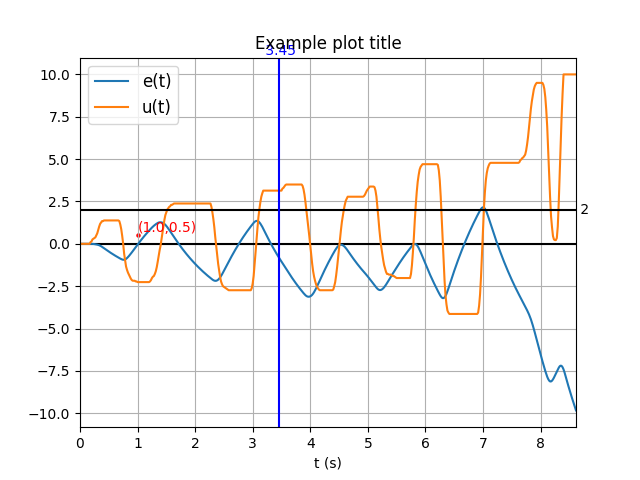

In [7]:
# Interactive plotting
%matplotlib ipympl
plt, ax = plot_flight(results)

# This sets the title of the plot
ax.set_title("Example plot title")

# This draws a black horizontal line annotation at y=2
annotate_line_h(ax, 2, color='black')

# This draws a blue line annotation at t=3.45
annotate_line_v(ax, 3.45, color='blue')

# This annotates a point with a red marker at t=1.0, y=0.5
annotate_point(ax, 1.0, 0.5, color='red')

plt.show()

### 1.5 Plotting Bode Diagrams

Bode diagrams are an important tool at your disposal for the analysis of these systems. The function `plot_bode_diagram`, with a full example below, will render a bode diagram of a plant (described by its transfer function) in series with a gain and delay. The parameters `f_min` and `f_max` describe the range of angular frequencies (in rad/s) over which to compute the Bode diagram. You should ensure that plots you produce for your report use a sensible frequency range.

As with the flight plots, these plots can be programmatically annotated (though it is also acceptable to print them out and annotate them by hand). Run the block of code below to verify that it correctly produces an annotated Bode diagram.

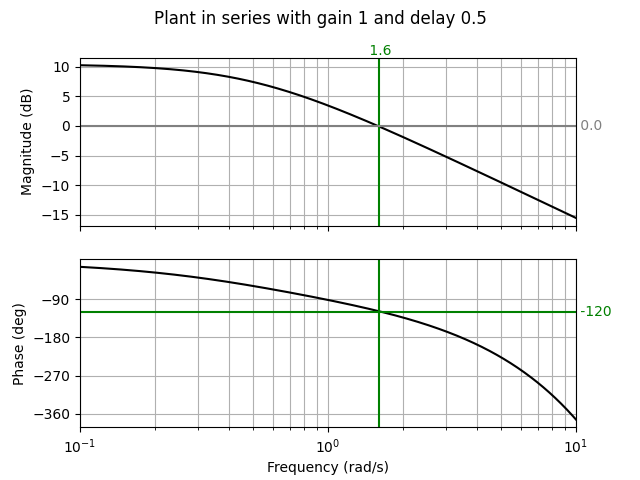

In [8]:
# Some example data for us to plot
num = [10]
den = [6, 3]
example_tf = TransferFunction(num, den)
gain = 1
delay = 0.5

# Generate a bode diagram.
# This returns handles to both the magnitude axis and the phase axis.
plt, magnitude_ax, phase_ax = plot_bode_diagram(example_tf, gain, delay, f_min=0.1, f_max=10.0)

# You can draw a vertical line across both axes at the same frequency value with this helper:
# (In this example, we draw the line at a frequency of 1.6 rad/s)
annotate_bode_line_v(magnitude_ax, phase_ax, 1.6, color='green')

# Or you can use the helpers from the previous section to annotate each axis individually
annotate_line_h(magnitude_ax, 0.0, color='gray')
annotate_line_h(phase_ax, -120, color='green')

# Finally, render the plot
plt.show()

## Part 2: Manual Control

### 2.1 Simplified Aircraft Model

We begin with a simplified aircraft model parameterised by $M$, a coefficient of aerodynamic damping, and $N$, a coefficient of aerodynamic effectiveness of the elevators:
$$
\ddot{y}(t) + M \dot{y}(t) = Nx(t)
$$

<font color="orange">[WORKSHEET] What is the Laplace transfer function of this plane? </font>

Set $M = N = 10$ and configure the corresponding plane transfer function in the code cell below. <font color="orange">[WORKSHEET] What should the values of `num` and `den` be to model this plane?</font> Try flying this plane by running the code cell after your modifcations.

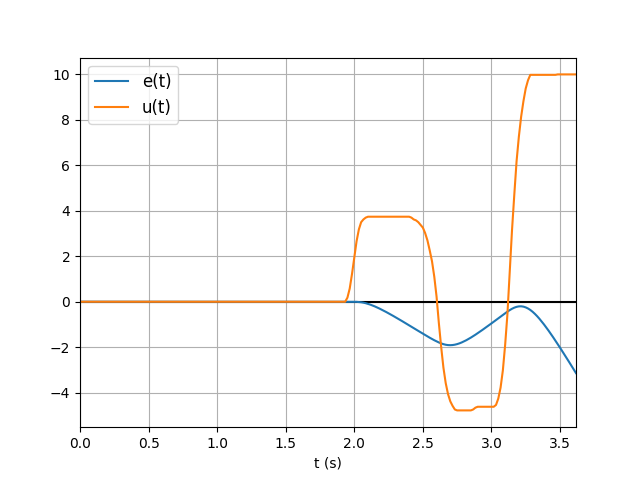

In [13]:
# Reminder: num and den are lists of numbers that describe
# a polynomial. For example, [1, 2, 3, 4] corresponds to
# the polynomial "1*s^3 + 2*s^2 + 3*s + 4".
M = 10
N = 10
num = [N] # YOUR VALUES HERE
den = [1,M,0] # YOUR VALUES HERE
plane_transfer_function = TransferFunction(num, den)

controller = ManualControl()

results = run_simulation(plant=plane_transfer_function,
                         controller=controller,
                         disturbance=None,
                         run_time_s=15)

plt, ax = plot_flight(results)
plt.show()

### 2.2 Modelling Manual Control

You, the pilot, are the controller in this system. In order to understand how your steering impacts the closed-loop system, we will construct a simple model of your behaviour: a proportional gain $k$ in series with a pure time delay $D$.

<font color="orange">[WORKSHEET] What is the Laplace transfer function of this model of the pilot? </font>

In order to help estimate $k$ and $D$, the code block below adds an impulse disturbance of magnitude 5. Under the hood, the impulse disturbance will start at a random time between $t=0.5s$ and $t=1.0s$, which will prevent the pilot from 'cheating' by anticipating the disturbance.

Run this simulation using the code block below and attempt to stabilise the plane (attempt to reduce $e(t)$ to 0). You may wish to try this several times.


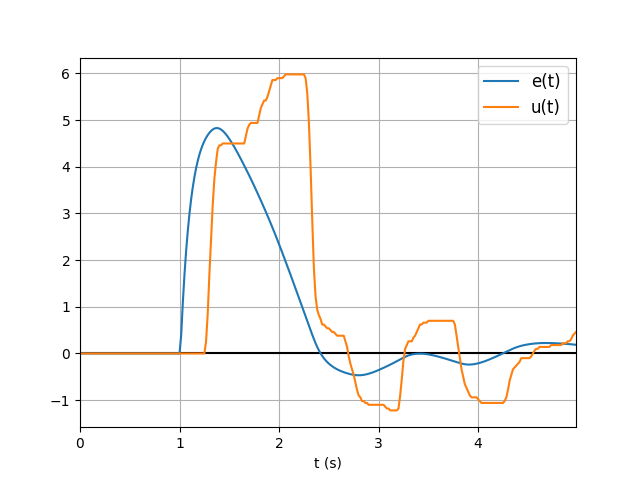

In [14]:
# This configures an impulse disturbance of magnitude 5
disturbance = ImpulseDisturbance(5)

results = run_simulation(plant=plane_transfer_function,
                         controller=controller,
                         disturbance=disturbance,
                         run_time_s=5)

plt, ax = plot_flight(results)
plt.show()

<font color="orange">[WORKSHEET] Estimate your values of $k$ and $D$ from the flight plot.</font>

Use the code block below to annotate your flight plot, showing how you found these quantities, and then <font color="red">[FIGURE 1] save the flight plot you used to estimate $k$ and $D$.</font>.

In [19]:
# save results
#np.save('manual_results.npy', results)


Time delay = 0.250 and gain, kp = 1.238


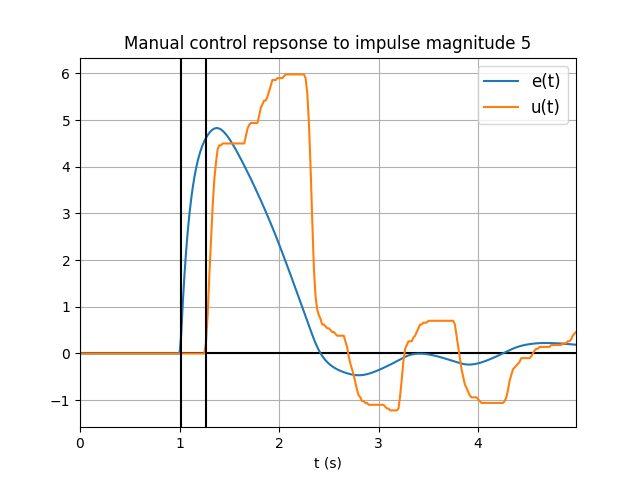

In [21]:
results = np.load('manual_results.npy', allow_pickle=True)
plt, ax = plot_flight(results)
ax.set_title("Manual control repsonse to impulse magnitude 5")

# YOUR ANNOTATIONS HERE
time, error, control = results

# SO control system input is 5, and output has magnitude 5k
Tcontrol = time[control > 0][0]
Terror = time[error > 0][0]
dt = Tcontrol - Terror
k =  np.max(control) / np.max(error)

print(f"Time delay = {dt:.3f} and gain, kp = {k:.3f}")

# annotate flight plot
ax.axvline(Tcontrol, c='black')
ax.axvline(Terror, c='black')
plt.savefig("figures/FIGURE_1", dpi=300)
plt.show()

Use the code block below to <font color="red">[figures/FIGURE_2] plot and save the bode diagram for the plane in series with this controller model.</font> Remember to select a suitable frequency range.

<font color="orange">[WORKSHEET] Estimate the phase margin. How much additional delay could this control loop tolerate before becoming unstable?</font>

<font color="purple">[REPORT 1] Use your Bode diagram to make a sketch of the Nyquist diagram.</font>

frequency at magnitude is 0 =  1.2230773140928937
gain margin = 4.042586344153659 and phase margin = 65.50762407398688
additional time delay 0.9347926840567139


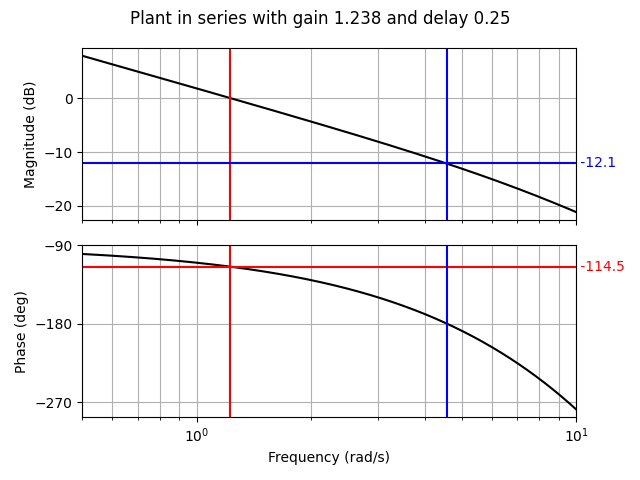

In [53]:
from scipy.signal import bode
controller_gain = 1.238 # YOUR VALUES HERE
controller_delay = 0.250 # YOUR VALUES HERE
plt, magnitude_ax, phase_ax = plot_bode_diagram(plane_transfer_function,
                                                controller_gain,
                                                controller_delay,
                                                f_min=0.5,
                                                f_max=10.0)

from flight_control.plots import get_magnitude_and_phase

W, magnitude, phase = get_magnitude_and_phase(plane_transfer_function, 
                                              controller_gain, 
                                              controller_delay, 
                                              f_min=0.5,
                                              f_max=10.0)

idx_one = np.where(np.isclose(magnitude, 0, atol=0.05))[0][0]
w_one = W[idx_one]
phase_ax.axvline(w_one, c='red')
magnitude_ax.axvline(w_one, c='red')
print("frequency at magnitude is 0 = ", w_one)
annotate_line_h(phase_ax, np.round(phase[idx_one],1), 'red')
phase_margin = 180 + phase[idx_one]
idx_180 = np.where(np.isclose(phase, -180, atol=0.5))[0][0]
w_180 = W[idx_180]
phase_ax.axvline(w_180, c='blue')
magnitude_ax.axvline(w_180, c='blue')
annotate_line_h(magnitude_ax, np.round(magnitude[idx_180],1), 'blue')
gain_at_180 = 10 ** (magnitude[idx_180] / 20)
gain_margin = 1 / gain_at_180
print(f"gain margin = {gain_margin} and phase margin = {phase_margin}")
additional_dt = phase_margin * np.pi / 180.0 * 1.0 / w_one
print(f"additional time delay {additional_dt}")


plt.tight_layout()
#plt.savefig("figures/FIGURE_2", dpi=300)
plt.show()

In the code block below, we consider a step disturbance instead of an impulse disturbance. Attempt to stabilise the plane under this new disturbance.

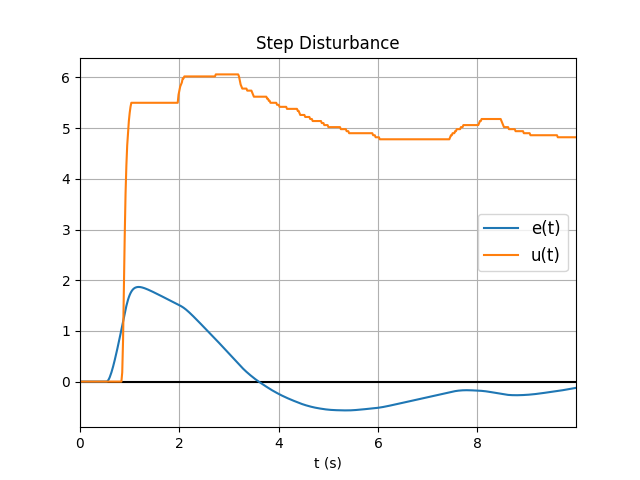

In [26]:
step_disturbance = StepDisturbance(5)
step_disturbance_results = run_simulation(plant=plane_transfer_function,
                                          controller=controller,
                                          disturbance=step_disturbance,
                                          run_time_s=10)


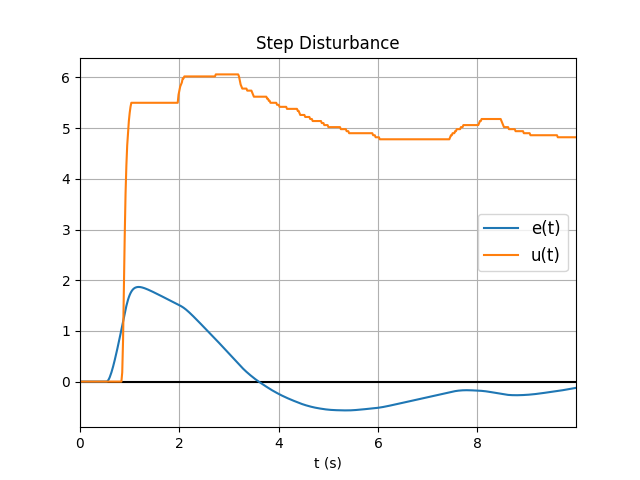

In [27]:
plt, ax = plot_flight(step_disturbance_results)
ax.set_title("Step Disturbance")
plt.savefig("figures/FIGURE_3")
plt.show()

<font color="red">[figures/FIGURE_3] Save the flight plot of the stabilised step disturbance.</font>

<font color="purple">[REPORT 2] Are you using any integral action? Give a brief explanation. What implications does this have for the accuracy of our pilot model?</font>

### 2.3 Pilot Induced Oscillation

You are now asked to fly a different aircraft. This aircraft has a poorly-designed control system, and can be modelled by the transfer function:

$$
G_1(s) = \frac{c}{(Ts+1)^3}
$$

Choose the parameters as follows: $T= 4D/\pi$ and $c=\sqrt{8}/k$ for your own estimated values of $k$ and $D$. Take an impulse of weight $5kD$ and attempt to bring the plane back to level flight.

Producing PIO parameters for: controller_gain=1.238, controller_delay=0.25


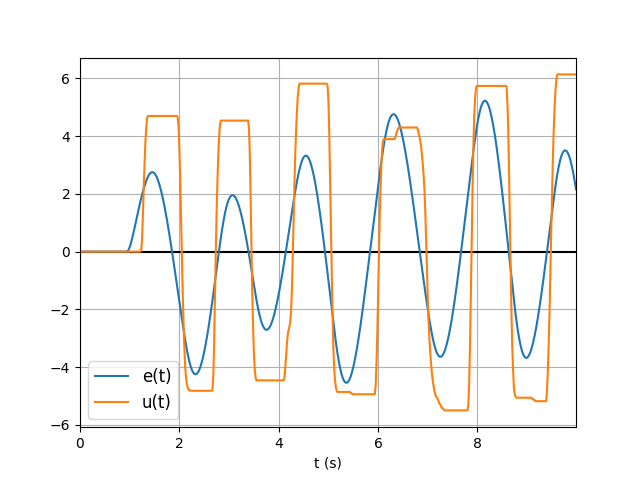

In [30]:
print(f"Producing PIO parameters for: controller_gain={controller_gain}, controller_delay={controller_delay}")
T = 4 * controller_delay / np.pi
num = np.sqrt(8) / controller_gain
den = [T**3, 3*T**2, 3*T, 1]
pio_transfer_function = TransferFunction(num, den)
disturbance_magnitude = 5 * controller_gain * controller_delay
pio_disturbance = ImpulseDisturbance(disturbance_magnitude)

pio_results = run_simulation(plant=pio_transfer_function,
                             controller=controller,
                             disturbance=pio_disturbance,
                             run_time_s=10)

plt, ax = plot_flight(pio_results)
plt.show()


You should observe a phenomenon traditionally known as 'pilot-induced oscillation' (PIO). Using the code block below, <font color="red">[FIGURE 4] save a flight plot in which PIO is present</font>. Then, for comparison <font color="red">[FIGURE 5] save a flight plot in with zero control input</font> (hint: you can disable control input entirely by setting `controller=None` in the `run_simulation` parameters). <font color="orange">[WORKSHEET] What is the observed period of the pilot-induced oscillation?</font>

Average period =  1.6541666666666734


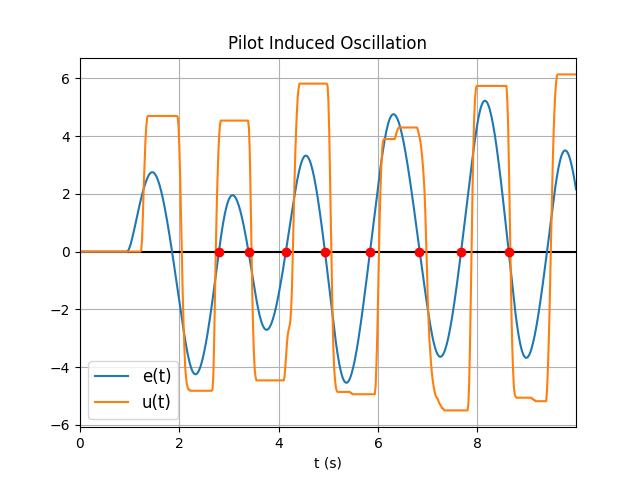

In [33]:
# Use this block of code to annotate your latest PIO flight

plt, ax = plot_flight(pio_results)

ax.set_title("Pilot Induced Oscillation")

# YOUR ANNOTATIONS HERE
time, error, control = pio_results

#error_ft = np.fft.fft(error)
#freq = np.linspace(0, len(error_ft))

finalerror = error[time > 2] # required so that
finaltime = time[time > 2]

maybe_find_zeros = finaltime[np.isclose(finalerror, 0, atol=0.1)]
find_zeros = []
for i in range(len(maybe_find_zeros) - 1):
    if np.isclose(maybe_find_zeros[i], maybe_find_zeros[i+1], atol = 0.5):
       continue
    else:
        find_zeros.append(maybe_find_zeros[i])

find_zeros = np.array(find_zeros)

finalzeros = np.zeros(len(find_zeros))

avg_period = np.mean(np.gradient(find_zeros)) * 2

print(f"Average period = ",avg_period)

plt.plot(find_zeros, finalzeros, "o", c="r")
plt.savefig("figures/FIGURE_4", dpi = 300)
plt.show()

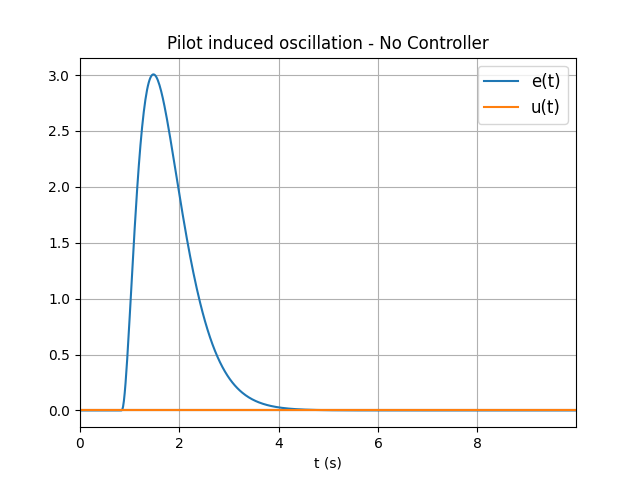

In [34]:
# Run the PIO plane without any human input by setting controller=None
pio_results_no_control = run_simulation(plant=pio_transfer_function,
                                        controller=None,
                                        disturbance=pio_disturbance,
                                        run_time_s=10)

plt, ax = plot_flight(pio_results_no_control)
ax.set_title("Pilot induced oscillation - No Controller")
plt.savefig("figures/FIGURE_5", dpi=300)
plt.show()

<font color="red">[FIGURE 6] Save the Bode diagram over a suitable frequency interval.</font> <font color="orange">[WORKSHEET] Use this plot to produce a theoretical prediction for the period of oscillation</font> and <font color="purple">[REPORT 3] explain the oscillation of the feedback loop. How does your observed period of oscillation compare to the theoretical prediction of the feedback loop?</font>

<font color="purple">[REPORT 4] Can you give a rough guideline to the control system designer to make PIO less likely?</font>

frequency at magnitude is 0 =  3.1379089001398603
gain margin = 0.9982426835831822 and phase margin = 0.1536003979698819


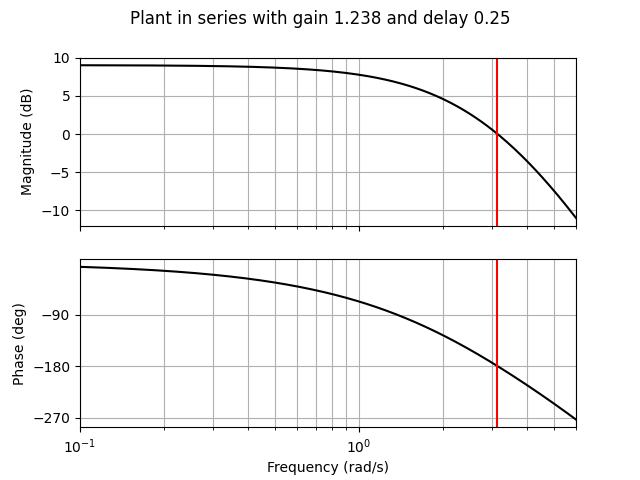

In [35]:
# Produce a Bode diagram for the PIO case
plt, magnitude_ax, phase_ax = plot_bode_diagram(pio_transfer_function,
                                                controller_gain,
                                                controller_delay,
                                                f_min=0.1,
                                                f_max=6)

# Annotate the Bode diagram if necessary
W, magnitude, phase = get_magnitude_and_phase(pio_transfer_function,
                                                controller_gain,
                                                controller_delay,
                                                f_min=0.1,
                                                f_max=6)

idx_one = np.where(np.isclose(magnitude, 0, atol=0.05))[0][0]
w_one = W[idx_one]
phase_ax.axvline(w_one, c='red')
magnitude_ax.axvline(w_one, c='red')
print("frequency at magnitude is 0 = ", w_one)
phase_margin = 180 + phase[idx_one]
idx_180 = np.where(np.isclose(phase, -180, atol=0.5))[0][0]
w_180 = W[idx_180]

gain_at_180 = 10 ** (magnitude[idx_180] / 20)
gain_margin = 1 / gain_at_180
print(f"gain margin = {gain_margin} and phase margin = {phase_margin}")

plt.savefig("figures/FIGURE_6", dpi=300)
plt.show()

### 2.4 Sinusoidal Disturbances

Next, we'll consider some models for the F4E fighter aircraft. The `F4E_FIGHTER_AIRCRAFT` dictionary contains models for the open loop dynamics of this aircraft linearised about 4 different operating points, with the control input being a fixed linear combination of the elvator and canard rudder deflections. A control system is necessary to make the aircraft flyable (but we won't do that in this lab!). Indeed, the first three operating points have unstable dynamics, and they are difficult-if-impossible to control manually.

Run the code cell below to import these aircraft models.

In [37]:
from flight_control.plane_models import F4E_FIGHTER_AIRCRAFT, F4E_FIGHTER_AIRCRAFT_DESCRIPTIONS

# F4E_FIGHTER_AIRCRAFT is a dictionary that contains the
# transfer functions of the aircraft at a variety of
# operating points
for key in F4E_FIGHTER_AIRCRAFT.keys():
    print(f"{key}: {F4E_FIGHTER_AIRCRAFT_DESCRIPTIONS[key]}")


operating_point_1: Altitude: 5000ft. Mach 0.5
operating_point_2: Altitude: 5000ft. Mach 0.85
operating_point_3: Altitude: 35000ft. Mach 0.9
operating_point_4: Altitude: 35000ft. Mach 1.5


 The fourth operating point is stable with a lightly damped mode, and can be steered manually. Try the following experiment (using the code block below): under a sinusoidal disturbance of amplitude 1 and frequency 0.66 Hz, try to keep the aircraft as close to level flight as possible over a 10 second run. <font color="red">[FIGURE 7] Save your flight plot</font>.

In [38]:
f4e_transfer_function = F4E_FIGHTER_AIRCRAFT['operating_point_4']
sinusoid_disturbance = SinusoidDisturbance(amplitude=1, frequency_hz=0.66)

Results object was empty


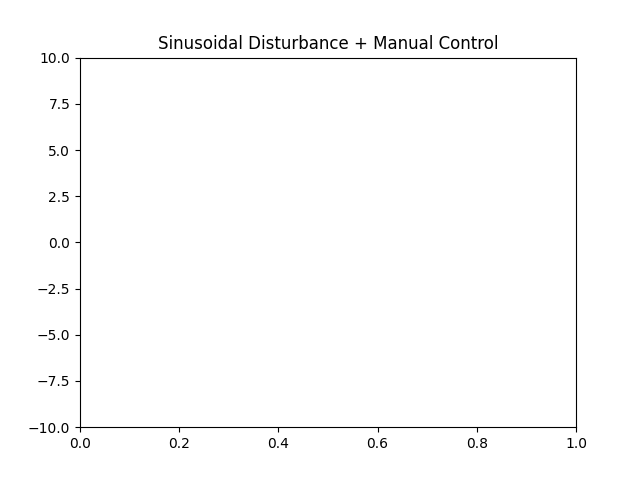

In [39]:


sinusoid_results = run_simulation(plant=f4e_transfer_function,
                                  controller=controller,
                                  disturbance=sinusoid_disturbance,
                                  run_time_s=10)

plt, ax = plot_flight(sinusoid_results)
ax.set_ylim(-10,10)
ax.set_title("Sinusoidal Disturbance + Manual Control")
#plt.savefig("figures/FIGURE_7", dpi=300)
plt.show()

Now, perform the same experiment with no control input (using the code block below) and <font color="red">[FIGURE 8] save this flight plot</font>.

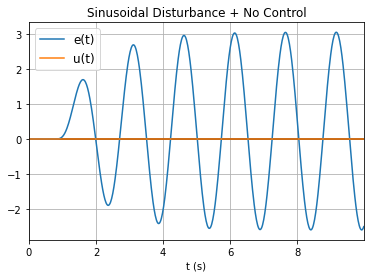

In [103]:
sinusoid_disturbance = SinusoidDisturbance(amplitude=1, frequency_hz=0.66)

sinusoid_results_no_control = run_simulation(plant=f4e_transfer_function,
                                  controller=None,
                                  disturbance=sinusoid_disturbance,
                                  run_time_s=10)

plt, ax = plot_flight(sinusoid_results_no_control)
ax.set_title("Sinusoidal Disturbance + No Control")
plt.savefig("figures/FIGURE_8", dpi=300)
plt.show()

Using the code block below, <font color="red">[FIGURE 9] produce a Bode diagram with a gain of 1 and your own estimated time delay</font>.

<font color="orange">[WORKSHEET] Use it to find (1) the maximum proportional gain for which the closed-loop system is stable, and (2) the gain and phase at 0.66 Hz</font>. 

gain margin = 0.3600187231699958


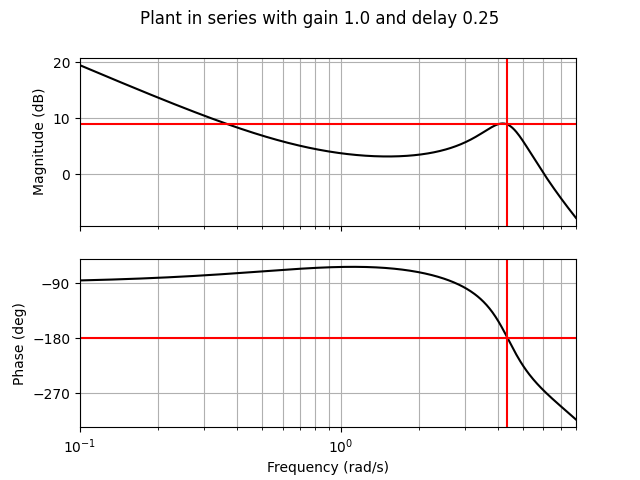

In [41]:
# Note: remember to select a sensible frequency range
plt, magnitude_ax, phase_ax = plot_bode_diagram(f4e_transfer_function,
                                                1.0,
                                                controller_delay,
                                                f_min=0.1,
                                                f_max=8)

W, magnitude, phase = get_magnitude_and_phase(  f4e_transfer_function,
                                                1.0,
                                                controller_delay,
                                                f_min=0.1,
                                                f_max=8)

# Annotate the Bode diagram if necessary

idx_180 = np.where(np.isclose(phase, -180, atol=1))[0][0]
w_180 = W[idx_180]

gain_at_180 = 10 ** (magnitude[idx_180] / 20)
gain_margin = 1 / gain_at_180
print(f"gain margin = {gain_margin}")

phase_ax.axhline(-180, c='red')
phase_ax.axvline(w_180, c='red')
magnitude_ax.axvline(w_180, c='red')
magnitude_ax.axhline(magnitude[idx_180], c='red')
plt.savefig("figures/FIGURE_9", dpi=300)

plt.show()

Finally, try to manually stabilise the plane using only very small mouse movements. <font color="red">[FIGURE 10] Save this flight plot</font>.

<font color="purple">[REPORT 5] Was your manual control able to reduce the error compared to no input? Compare all three cases (manual control, no control, manual control with small movements).</font>

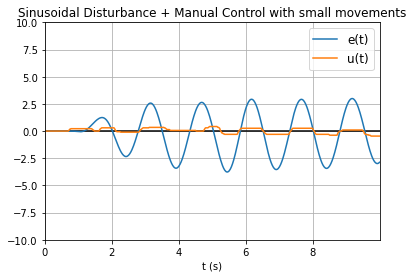

In [105]:
sinusoid_disturbance = SinusoidDisturbance(amplitude=1, frequency_hz=0.66)

sinusoid_results_small_movements = run_simulation(plant=f4e_transfer_function,
                                  controller=controller,
                                  disturbance=sinusoid_disturbance,
                                  run_time_s=10)

plt, ax = plot_flight(sinusoid_results_small_movements)
ax.set_ylim(-10,10)
ax.set_title("Sinusoidal Disturbance + Manual Control with small movements")
plt.savefig("figures/FIGURE_10", dpi=300)
plt.show()

### 2.5 An Unstable Aircraft

Now consider the control of an unstable aircraft, using the simplified model:

$$
G_2(s) = \frac{2}{-1+sT}
$$

Implement this aircraft by setting `num` and `den` in the code block below.

This has an unstable pole at $1/T$. Start with $T=1$ and attempt to stabilise an impulse disturbance of magnitude 0.1 over the course of a 5 second simulation. Decrease $T$ and try again, repeating until you find the point at which you can no longer stabilise the plane.

<font color="orange">[WORKSHEET] What is the fastest pole you can stabilise?</font>.

<font color="red">[FIGURE 11] Save the flight plot for this case</font> (you should find it is quite oscillatory). 

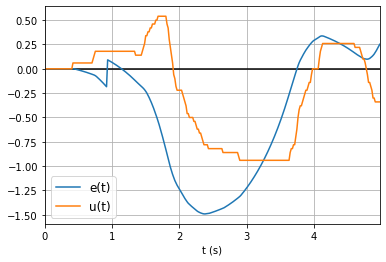

In [125]:
T = 0.7
num = [2] # YOUR VALUES HERE
den = [T,-1] # YOUR VALUES HERE
unstable_transfer_function = TransferFunction(num, den)
small_disturbance = ImpulseDisturbance(0.1)

unstable_aircraft_results = run_simulation(plant=unstable_transfer_function,
                                           controller=controller,
                                           disturbance=small_disturbance,
                                           run_time_s=5)

plt, ax = plot_flight(unstable_aircraft_results)
#plt.savefig("figures/FIGURE_11", dpi=300)
plt.show()

<font color="purple">[REPORT 6] Sketch the Nyquist diagram of $G_2$</font> (hint: it is exactly circular).

<font color="purple">[REPORT 7] Explain, using the Nyquist criterion, why the feedback system is stable with a proportional gain greater than 0.5</font>

<font color="purple">[REPORT 8] Finally, show how the Nyquist diagram is modified if a small time delay $D$ is introduced to the system</font>.

## Part 3: Autopilot

### 3.1 The Transport Aircraft

Consider the following model for a transport aircraft on approach to landing:

$$
G_3(s) = \frac{6.3s^2 + 4.3s + 0.28}{s^5 + 11.2s^4 + 19.6s^3 + 16.2s^2 + 0.91s + 0.27}
$$

Fly this plane manually. You should find it quite sluggish to respond. With an impulse disturbance of magnitude 10, a runtime of 60 seconds, and no control input, you should observe a very slow, lightled damped oscillation. This is called the _phugoid mode_ in aircraft dynamics.

Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: flight_control.controller.ManualControl


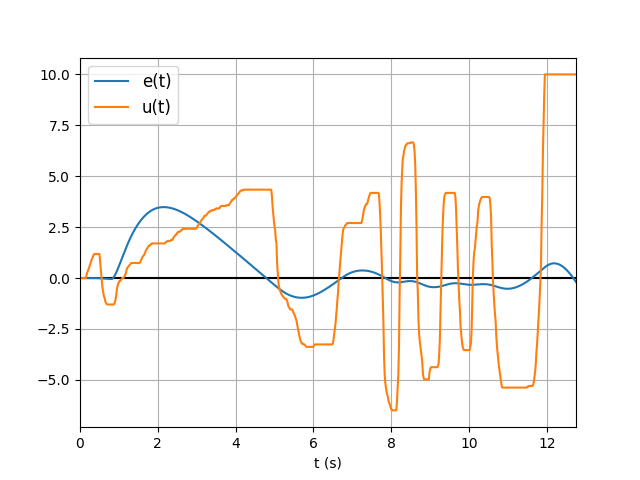

In [ ]:
num = [6.3, 4.3, 0.28] # YOUR VALUES HERE
den = [1, 11.2, 19.6, 16.2, 0.91, 0.27] # YOUR VALUES HERE
plane_transfer_function = TransferFunction(num, den)

controller = ManualControl()

disturbance = ImpulseDisturbance(10)

results = run_simulation(plant=plane_transfer_function,
                         controller=controller,
                         disturbance=disturbance,
                         run_time_s=60)

plt, ax = plot_flight(results)
plt.show()

### 3.2 A Proportional Controller

Our task is to design an autopilot for the transport aircraft. We start by implementing a simple proportional feedback control, described by:

$$
u(t) = Ke(t)
$$

This is implemented for you below as an example. Each step of the simulation, the simulation will call the `update` method of the supplied controller object providing the latest value of the error signal $e(t)$, as well as the time elapsed (in seconds) since the update method was last called. Try this example for an impulse disturbance of magnitude 2 and a runtime of 15 seconds.


Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: __main__.ProportionalControl


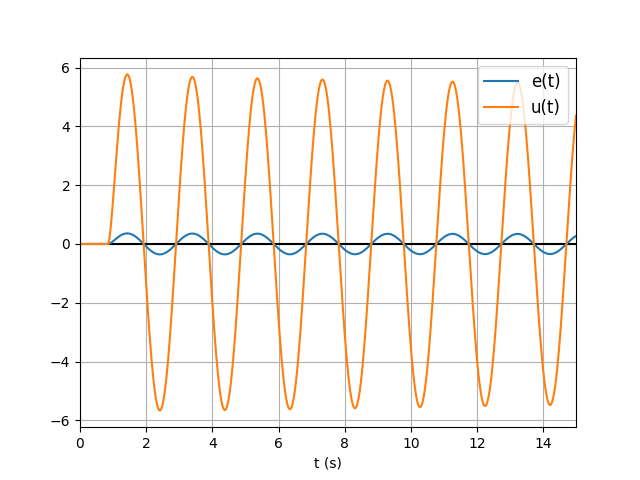

In [ ]:
class ProportionalControl:
    def __init__(self, gain):
        self.current_control = 0
        self.gain = gain

    def get_control(self):
        return self.current_control

    def update(self, error_signal, delta_t):
        self.current_control = error_signal * self.gain


autopilot = ProportionalControl(gain=16)

disturbance = ImpulseDisturbance(2)

results = run_simulation(plant=plane_transfer_function,
                         controller=autopilot,
                         disturbance=disturbance,
                         run_time_s=15)

plt, ax = plot_flight(results)
#plt.savefig("FIGURE 12")
plt.show()

You should notice that the phugoid mode of the aircraft has been stabilised. Now, gradually increase the proportional gain and re-run the simulation until the closed loop system just oscillates. This is the critical gain $K_c$, and the corresponding period of oscillation is $T_c$.

<font color="red">[FIGURE 12] Save the flight plot corresponding to critical gain</font>.

<font color="orange">[WORKSHEET] Record your values of $K_c$ and $T_c$</font>.


In [ ]:
# Your code here.

time, error, control = results

finalerror = error[time > 4] # required so that
finaltime = time[time > 4]

find_zeros = finaltime[np.isclose(finalerror, 0, atol=0.01)]
finalzeros = np.zeros(len(find_zeros))

avg_period = np.mean(np.gradient(find_zeros)) * 2

print(f"Average period = ",avg_period)

# You should add annotations to the flight plot to show
# how you found K_c and T_c

Average period =  1.9666666666667292


### 3.3 A PID Controller

We will now implement a more sophisticated autopilot in the form of a PID (proportional-integral-derivative) controller, which can be expressed as:

$$
u(t) = K_p \left ( e(t) + \frac{1}{Ti}\int_{0}^{t}e(\tau)\mathrm{d}\tau + T_d\frac{\mathrm{d} e}{\mathrm{d} t} \right )
$$

<font color="orange">[WORKSHEET] What is the transfer function of this controller?</font>

There are several methods to tune the constants of this controller to produce desirable behaviour. We will use the Ziegler-Nichols rules, which selects the following values:

$$
K_p=0.6K_c, \;\;\;\; T_i=0.5T_c, \;\;\;\; T_d = 0.125T_c
$$

<font color="orange">[WORKSHEET] Record your choice of PID controller contants</font>.

A PID controller is *partially* implemented for you below. It implements the part of update rule for the derivative term, but leaves implementation of the integral term to you. In the code block bellow, complete the integral update rule and add your PID controller constants.

Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: __main__.PidControl


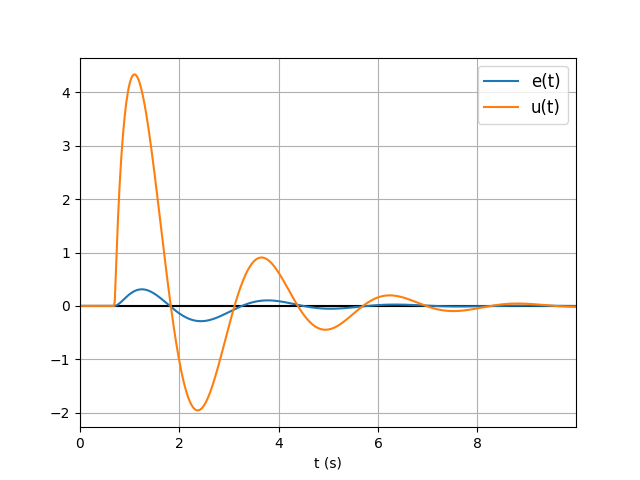

In [ ]:
class PidControl:
    def __init__(self, Kp, Ti, Td):
        self.current_control = 0
        self.integrator_term = 0
        self.derivative_term = 0
        self.prev_error = 0

        self.Kp = Kp
        self.Ti = Ti
        self.Td = Td

    def get_control(self):
        return self.current_control

    def update(self, error_signal, delta_t):
        self.derivative_term = (error_signal - self.prev_error) / delta_t

        # YOUR CODE HERE:
        # (an update rule for the integrator term)
        # e.g. self.integrator_term = ???
        self.integrator_term += delta_t * error_signal

        self.current_control = self.Kp * (error_signal + self.integrator_term / self.Ti + self.derivative_term * self.Td)
        self.prev_error = error_signal
        

# YOUR VALUES OF PID CONSTANTS HERE
Kp = 9.6
Ti = 0.9835
Td = 0.2459

autopilot = PidControl(Kp=Kp, Ti=Ti, Td=Td)

results = run_simulation(plant=plane_transfer_function,
                         controller=autopilot,
                         disturbance=disturbance,
                         run_time_s=10)

plt, ax = plot_flight(results)
plt.show()

Now, we'll test your PID controller under more demanding circumstances. The `CompositeDisturbance` class allows us to subject the system to multiple disturbances simultaneously. You should observe the effect of integral action as it corrects for the step disturbance.

Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: __main__.PidControl


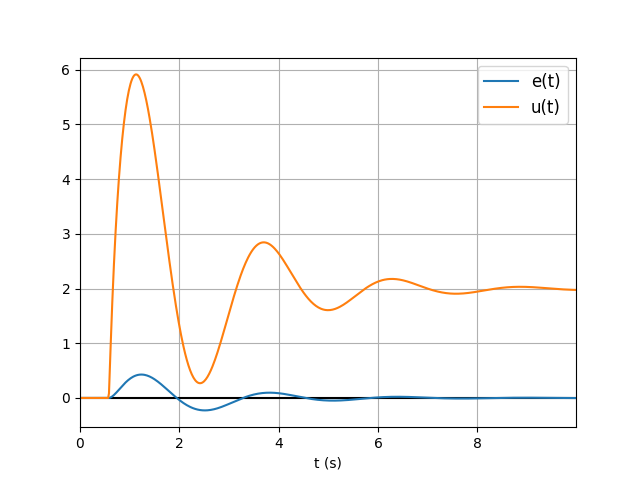

In [ ]:
autopilot = PidControl(Kp=Kp, Ti=Ti, Td=Td)
impulse_disturbance = ImpulseDisturbance(2)
step_disturbance = StepDisturbance(2)
composite_disturbance = CompositeDisturbance([impulse_disturbance, step_disturbance])

results = run_simulation(plant=plane_transfer_function,
                         controller=autopilot,
                         disturbance=composite_disturbance,
                         run_time_s=10)

plt, ax = plot_flight(results)
plt.show()

You will have found your response quite oscilliatory. Increase the gain for the derivative term by 40% (<font color="orange">[WORKSHEET] and record the corresponding new value of $T_d$</font>), and observe the reduced oscillation.

<font color="red">[FIGURE 13] Save the flight plot for these PID controller settings</font>.

Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: __main__.PidControl


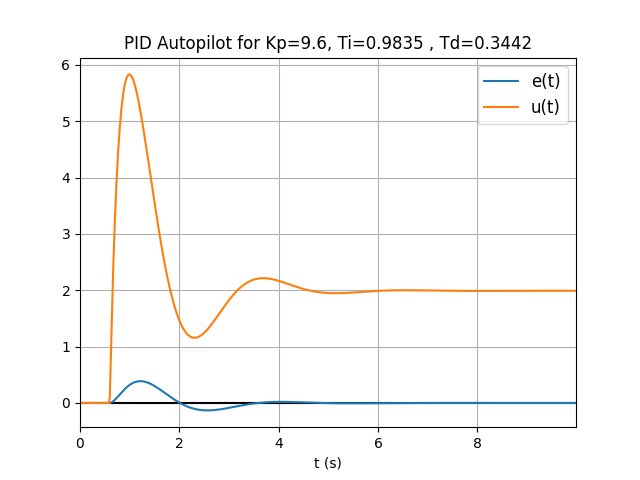

In [ ]:
# YOUR VALUE OF NEW TD here
new_Td = 0.3442
autopilot = PidControl(Kp=Kp, Ti=Ti, Td=new_Td)
impulse_disturbance = ImpulseDisturbance(2)
step_disturbance = StepDisturbance(2)
composite_disturbance = CompositeDisturbance([impulse_disturbance, step_disturbance])

results = run_simulation(plant=plane_transfer_function,
                         controller=autopilot,
                         disturbance=composite_disturbance,
                         run_time_s=10)

plt, ax = plot_flight(results)

ax.set_title(f"PID Autopilot for Kp={Kp}, Ti={Ti} , Td={new_Td}")
#plt.savefig("FIGURE 13")
plt.show()

### 3.4 Integrator wind-up

We will now expose the plane and autopilot to a larger disturbance. When you run this cell, you should observe 'integrator wind-up'. This can cause unwanted overshoot/undershoot after a period of input saturation, due to the integrator being 'wound up' and having to unload again.

<font color="red">[FIGURE 14] Save this flight plot demonstrating overshoot/undershoot from integrator wind-up</font>.

Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: __main__.PidControl


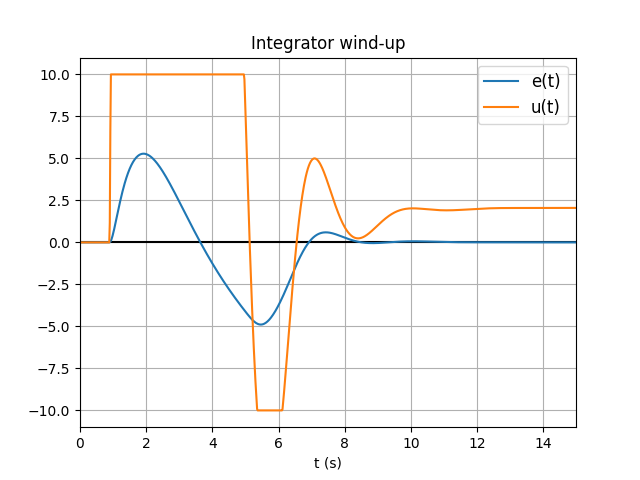

In [ ]:
# Configure your autopilot here
autopilot = PidControl(Kp=Kp, Ti=Ti, Td=new_Td)
impulse_disturbance = ImpulseDisturbance(20)
step_disturbance = StepDisturbance(2)
composite_disturbance = CompositeDisturbance([impulse_disturbance, step_disturbance])
results = run_simulation(plant=plane_transfer_function,
                         controller=autopilot,
                         disturbance=composite_disturbance,
                         run_time_s=15)

plt, ax = plot_flight(results)
ax.set_title("Integrator wind-up")
#plt.savefig("figures/FIGURE_14")
plt.show()

A simple way to correct for integrator wind-up is to prevent the integrator state from ever getting too large. We can limit the absolute value of the stored integrator to lie beneath a particular bound. This is improvement is implemented in the controller class below. Carry over your update rule for the integrator term into this controller and run the simulation.

Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: __main__.ImprovedPidControl


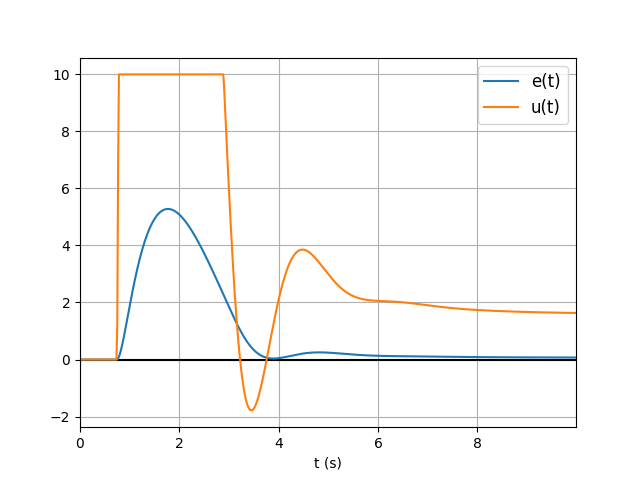

In [ ]:
class ImprovedPidControl:
    def __init__(self, Kp, Ti, Td, max_windup):
        self.current_control = 0
        self.integrator_term = 0
        self.derivative_term = 0
        self.prev_error = 0

        self.Kp = Kp
        self.Ti = Ti
        self.Td = Td
        self.max_windup = max_windup

    def get_control(self):
        return self.current_control

    def update(self, error_signal, delta_t):
        self.derivative_term = (error_signal - self.prev_error) / delta_t

        # YOUR CODE HERE:
        # (i.e. replicate your update rule for the integrator term)
        self.integrator_term += delta_t * error_signal
        # We've added a guard for integrator wind up.
        # The clip function will 'clip' a value to lie within the bounds a_min to a_max:
        # Values less than the a_min value are set to the a_min value
        # Values greater than the a_max valuea re set to the a_max value
        self.integrator_term = np.clip(self.integrator_term, a_min=-self.max_windup, a_max=self.max_windup)
        

        self.current_control = self.Kp * (error_signal + self.integrator_term / self.Ti + self.derivative_term * self.Td)
        self.prev_error = error_signal

integrator_term_bound = 0.1
autopilot = ImprovedPidControl(Kp=Kp, Ti=Ti, Td=new_Td, max_windup=integrator_term_bound)
results = run_simulation(plant=plane_transfer_function,
                         controller=autopilot,
                         disturbance=composite_disturbance,
                         run_time_s=10)

plt, ax = plot_flight(results)
plt.show()

You should find that while the overshoot/undershoot issue is improved, the autopilot is no longer correcting the step disturbance adequately: there is a small steady-state error. If you increase `integrator_term_bound` to 20, you will find that the step disturbance _is_ corrected, but the overshoot/undershoot issue is worse. We have encountered a design trade-off!

<font color="orange">[WORKSHEET] Determine the smallest possible value $Q$ that `integrator_term_bound` can take while correcting a steady-state disturbance of magnitude 2 (hint: you should be able to do this analytically by considering the time-domain expression for your PID controller in the steady-state).</font>

<font color="purple">[REPORT 9] Explain your reasoning for this bound on $Q$</font>.

<font color="red">[FIGURE 15] Save the flight plot with `integrator_term_bound` set to $Q$</font>.

Plane transfer function:
num = 6.3*s^2 + 4.3*s^1 + 0.28
den = 1.0*s^5 + 11.2*s^4 + 19.6*s^3 + 16.2*s^2 + 0.91*s^1 + 0.27
Controller type: __main__.ImprovedPidControl


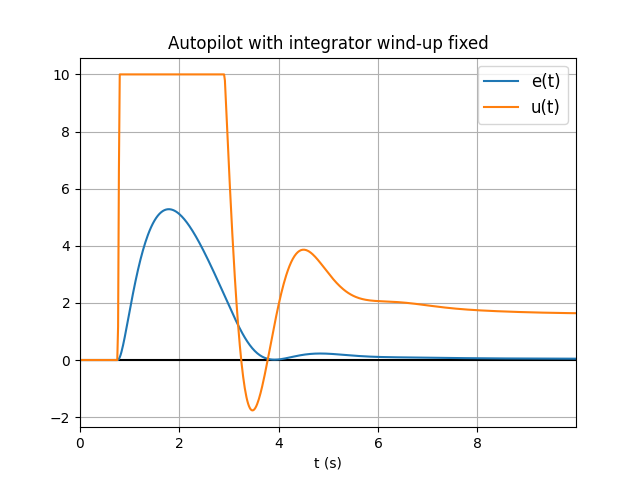

In [ ]:
integrator_term_bound = 0.1229 # YOUR VALUE FOR Q HERE
autopilot = ImprovedPidControl(Kp=Kp, Ti=Ti, Td=new_Td, max_windup=integrator_term_bound)
results = run_simulation(plant=plane_transfer_function,
                         controller=autopilot,
                         disturbance=composite_disturbance,
                         run_time_s=10)

plt, ax = plot_flight(results)

ax.set_title("Autopilot with integrator wind-up fixed")
#plt.savefig("figures/FIGURE_15")
plt.show()

## Part 4: Discrete Systems (Full Technical Report ONLY)

This section contains some additional material for students wishing to submit an FTR. Those students not submitting an FTR for this lab may ignore this section.

*Note:* If you are coming back to this section after the finishing lab session and want to run this code, remember to run the code block in the introduction section (1.3) to import the required libraries.

### 4.1 Manual Control of a Discrete System

Consider again the transfer function you derived for the simplified model of the aeroplane in Section 2.1:
$$
\ddot{y}(t) + M \dot{y}(t) = Nx(t)
$$

Once again, set $M=N=10$ and consider an impulse disturbance of magnitude 5. The new twist is that we will discretise the rate of simulation at 10 Hz by setting the `frame_rate_hz` parameter of the `run_simulation` function. This will affect both the plant, as it will now be simulated with large time steps, and you, the controller, as you may react differently to receiving visual feedback at longer intervals. Try flying and stabilising the plane under these conditions.

Plane transfer function:
num = 10.0
den = 1.0*s^2 + 10.0*s^1 + 0.0
Controller type: flight_control.controller.ManualControl


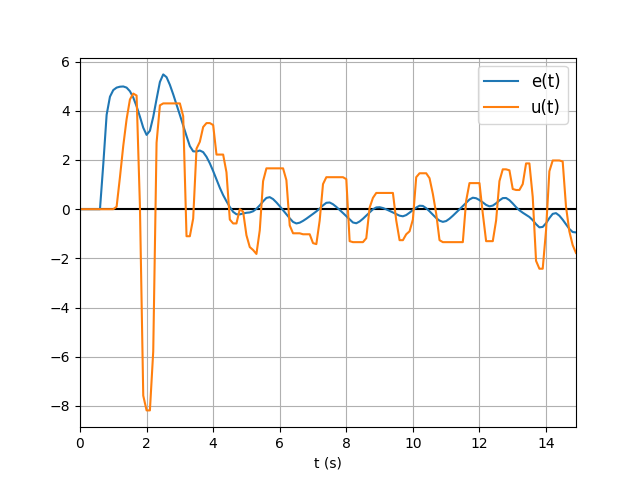

In [ ]:
# Use the values of num and den from the earlier section 2.1
num = [N] # YOUR VALUES HERE
den = [1,M,0] # YOUR VALUES HERE
plane_transfer_function = TransferFunction(num, den)

controller = ManualControl()

disturbance = ImpulseDisturbance(5)

results = run_simulation(plant=plane_transfer_function,
                         controller=controller,
                         disturbance=disturbance,
                         frame_rate_hz=10,
                         run_time_s=15)

plt, ax = plot_flight(results)
#plt.savefig("FTR FIGURE 1")
plt.show()

<font color="red">[FTR FIGURE] Save a representative flight plot</font>.

<font color="purple">[FTR DISCUSSION] Comment on whether you found the system easier or harder to stabilise at 10Hz</font>.

### 4.2 Behind the Curtain

In sections 1, 2, and 3, the system was simulated at 60 Hz. This level of discretisation was sufficiently fine-grained that events on the timescales of human reflexes and our plane models were not impacted. Now that we have increased our sampling period, we need to take into account how discretisation can affect our modelling.

By default, the simulation uses a naïve 'Zero-Order Hold' method. The 3F1 module covers various methods for converting between the continuous and discrete domain. You can experiment with several of these techniques by modifying the `discretisation_method` parameter of the `run_simulation` function. The supported methods are:

* `'zoh'`: Zero-Order Hold
* `'bilinear`: Tustin's transformation
* `'euler'`: Euler's method (a.k.a. Forward Difference)
* `'backward_diff`: Backward Difference

Lower the frame rate to 5 Hz and attempt to fly the plane with the `bilinear` discretisation method. Now repeat this with the `euler` method.

<font color="red">[FTR FIGURE] Save representative flight plots for both cases.</font>.

<font color="purple">[FTR DISCUSSION] Comment on the discrepancy between the two methods. Can you explain why Euler's method produces such an inadequate simulation?</font>.

Plane transfer function:
num = 10.0
den = 1.0*s^2 + 10.0*s^1 + 0.0
Controller type: flight_control.controller.ManualControl


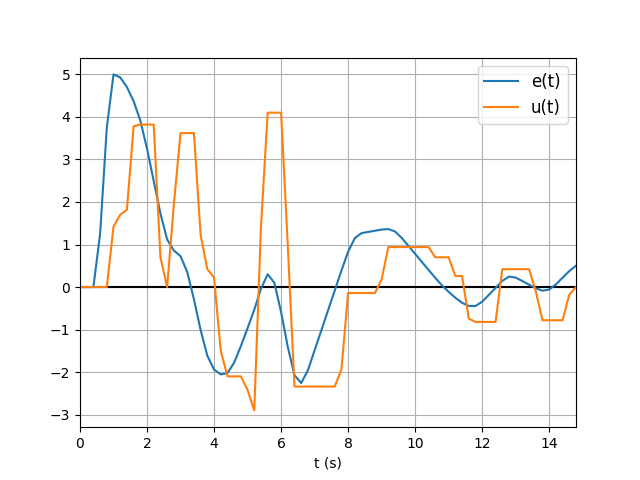

In [ ]:
results = run_simulation(plant=plane_transfer_function,
                         controller=controller,
                         disturbance=disturbance,
                         frame_rate_hz=5,
                         discretisation_method='bilinear',
                         run_time_s=15)

plt, ax = plot_flight(results)
#plt.savefig("FTR figures/FIGURE_2")
plt.show()

# Finishing up

This is the end of the 3F1 Lab. You may find it useful to make a PDF copy of each of these notebooks to consult when writing up your report. To do this, simply select 'Print' in your browser to print the webpage, and then select 'Save to PDF' as the printer. You _should not_ submit this copy with your report.

If you would like to submit a FTR on this lab, consult the handout for additional instructions.

In order to help you make sure you've included all relevant figures in your report, the table below summarises each figure mentioned in the body of the text.

| Figure No. | Section | Description                                                                              |
|------------|---------|------------------------------------------------------------------------------------------|
| 1          | 2.2     | Flight plot used to estimate k and D                                                     |
| 2          | 2.2     | Bode diagram used to estimate phase margin                                               |
| 3          | 2.2     | Flight plot for step disturbance                                                         |
| 4          | 2.3     | Flight plot showing pilot induced oscillation with manual control                        |
| 5          | 2.3     | Flight plot for the same aircraft and disturbance as Fig. 4, but with zero control input |
| 6          | 2.3     | Bode diagram for the pilot induced oscillation aircraft                                  |
| 7          | 2.4     | Flight plot showing manual control under sinusoidal disturbance                          |
| 8          | 2.4     | Flight plot showing zero control under sinusoidal disturbance                            |
| 9          | 2.4     | Bode diagram for the F4E fighter aircraft with gain 1 and your own time delay            |
| 10         | 2.4     | Flight plot showing use of very small manual control inputs under sinusoidal disturbance |
| 11         | 2.5     | Flight plot showing fastest pole you can manually stabilise for the unstable aircraft    |
| 12         | 3.2     | Flight plot used to derive K_c and T_c                                                   |
| 13         | 3.3     | Flight plot showing a PID autopilot stabilising a composite disturbance                  |
| 14         | 3.4     | Flight plot showing integrator wind-up                                                   |
| 15         | 3.5     | Flight plot showing that you have fixed integrator wind-up                               |